# Negative feedback loop

In [1]:
import stochpy


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

StochPy uses the [PySCeS MDL](https://stochpy.sourceforge.net/html/inputfile_doc.html#pysces-inputfile), an ASCII text based input file to describe a system in terms of it’s stoichiometry, kinetics, compartments and parameters. We defined the system using such format and saved it in the file `../long_range_models/negative_feedback_loop.psc`:

In [2]:
!cat ../long_range_models/negative_feedback_loop.psc

# Negative feedback loop

# G1 --> 10, G1 + P1
# G2 --> 10000, G2 + P2
# G3 --> 10, G3 + P3
# P1 + G2, 2 <--> 10, P1G2
# P2 + G3, 20 <--> 0.1, P2G3
# P3 + G1, 20 <--> 10, P3G1
# P1 --> 1,
# P2 --> 100,
# P3 --> 1,

R1:
    G1 > G1 + P1
    G1*RP1

R2:
    G2 > G2 + P2
    G2*RP2

R3:
    G3 > G3 + P3
    G3*RP3

R4:
    P1 + G2 > P1G2
    P1*G2*RB1

R5:
    P1G2 > P1 + G2
    P1G2*RU1

R6:
    P2 + G3 > P2G3
    P2*G3*RB2

R7:
    P2G3 > P2 + G3
    P2G3*RU2

R8:
    P3 + G1 > P3G1
    P3*G1*RB3

R9:
    P3G1 > P3 + G1
    P3G1*RU3

R10:
    P1 > $pool
    P1*RD1

R11:
    P2 > $pool
    P2*RD2

R12:
    P3 > $pool
    P3*RD3

# Parameters
RP1 = 10
RP2 = 10000
RP3 = 10
RB1 = 10
RU1 = 2
RB2 = 0.1
RU2 = 20
RB3 = 10
RU3 = 20
RD1 = 1
RD2 = 100
RD3 = 1

# Init Values
P1 = 0
P2 = 0
P3 = 0
G1 = 1
G2 = 1
G3 = 1
P1G2 = 0
P2G3 = 0
P3G1 = 0


Loading the model:

In [3]:
smod = stochpy.SSA(IsQuiet=False)
smod.Model(model_file="negative_feedback_loop.psc",dir="../long_range_models/")
smod.ShowSpecies()

Info: Direct method is selected to perform stochastic simulations.
Parsing file: /Users/irenetesta/Stochpy/pscmodels/ImmigrationDeath.psc
Info: No reagents have been fixed
Parsing file: ../long_range_models/negative_feedback_loop.psc
Info: No reagents have been fixed
['G1', 'P1', 'G2', 'P2', 'G3', 'P3', 'P1G2', 'P2G3', 'P3G1']


The method to perform a stochastic simulation is `DoStochSim`:

In [4]:
help(smod.DoStochSim)

Help on method DoStochSim in module stochpy.modules.StochSim:

DoStochSim(end=False, mode=False, method=False, trajectories=False, epsilon=0.03, IsTrackPropensities=False, rate_selection=None, species_selection=None, IsOnlyLastTimepoint=False, critical_reactions=[], reaction_orders=False, species_HORs=False, species_max_influence=False, quiet=False) method of stochpy.modules.StochSim.SSA instance
    Run a stochastic simulation for until `end` is reached. This can be either time steps or end time (which could be a *HUGE* number of steps).
    
    Input:
     - *end* [default=1000] (float) simulation end (steps or time)
     - *mode* [default='steps'] (string) simulation mode, can be one of: ['steps','time']
     - *method* [default='Direct'] (string) stochastic algorithm ['Direct', 'FRM', 'NRM', 'TauLeap']
     - *trajectories* [default = 1] (integer)
     - *epsilon* [default = 0.03] (float) parameter for the tau-leap method
     - *IsTrackPropensities* [default = False]
     - *rate

In the following, we will only use the Direct method as its variants are designed to reduce computational costs, which is not a concern for the simulations we will perform.

Performing a stochastic simulation using default parameters:

Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 1000 End time 0.05356876453151494
Info: Simulation time 0.01578


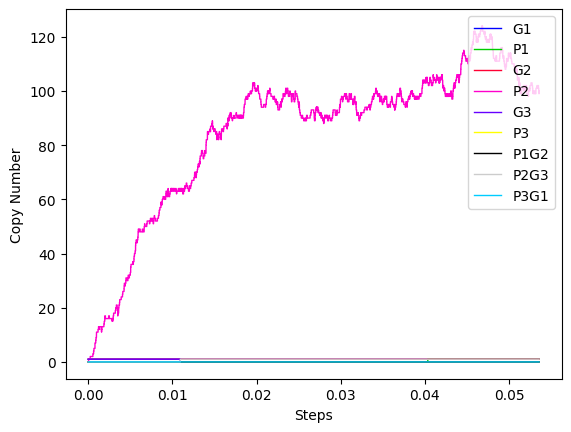

In [5]:
smod.DoStochSim(IsTrackPropensities=True)
smod.PlotSpeciesTimeSeries(xlabel="Steps")

Visualizing reaction propensities:

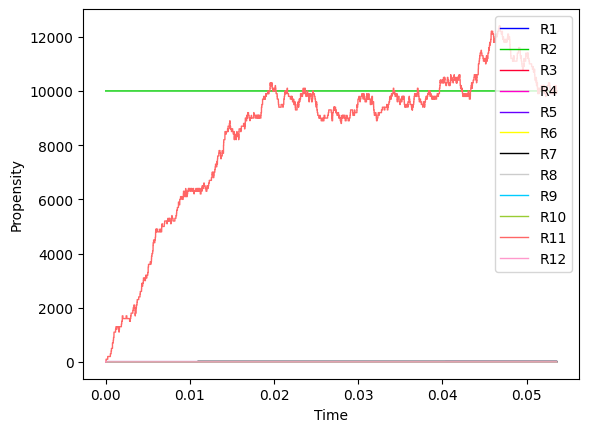

In [6]:
smod.PlotPropensitiesTimeSeries()

Plotting the time between two subsequent firings of a reaction:

/Users/irenetesta/anaconda3/envs/stochpy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/irenetesta/anaconda3/envs/stochpy/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Reaction	Mean
R1	nan
R2	9.767e-05
R3	nan
R4	nan
R5	nan
R6	nan
R7	nan
R8	nan
R9	nan
R10	nan
R11	1.169e-04
R12	nan


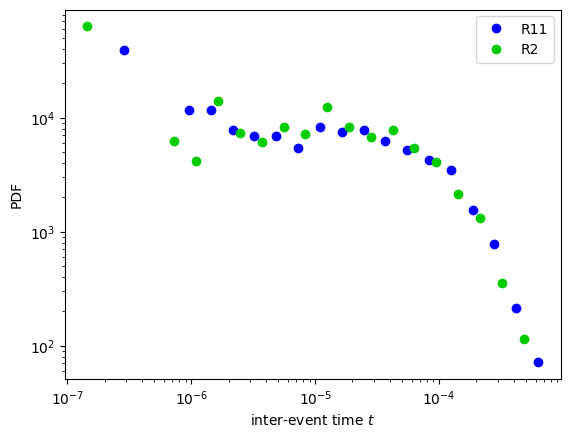

In [7]:
smod.PlotWaitingtimesDistributions()
smod.PrintWaitingtimesMeans()

To approximate the deterministic behavior we can either perform multiple stochastic simulations and average the species copy numbers at each time point:

Info: 100 trajectories are generated
Info: Time simulation output of the trajectories is stored at negative_feedback_loop(trajectory).dat in directory: /Users/irenetesta/Stochpy/temp
Info: Simulation time: 0.19410014152526855                                                   

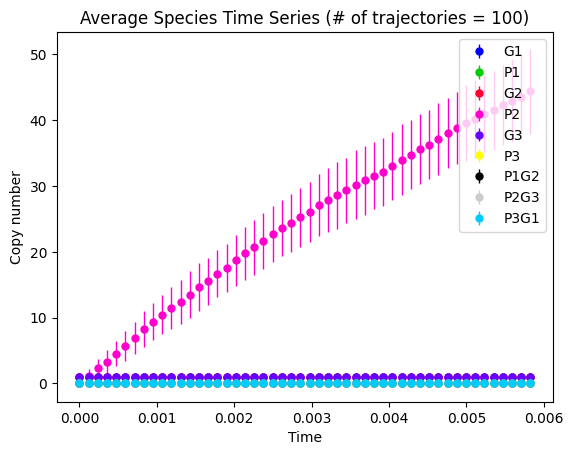

In [8]:
smod.DoStochSim(end=100, trajectories=100)
smod.GetRegularGrid(n_samples=50)
smod.PlotAverageSpeciesTimeSeries()

Computing mean and standard deviation of the species copy number is not straightforward as the time between two events is not constant, thus it is necessary to track the time spent in each state for each species. This computation is implemented by the following functions:

In [9]:
smod.PrintSpeciesMeans()
smod.PrintSpeciesStandardDeviations()

Species	Mean
G1	1.000
P1	0.000e+00
G2	1.000
P2	25.239
G3	1.000
P3	0.000e+00
P1G2	0.000e+00
P2G3	0.000e+00
P3G1	0.000e+00
Species	Standard Deviation
G1	0.000e+00
P1	0.000e+00
G2	0.000e+00
P2	12.625
G3	0.000e+00
P3	0.000e+00
P1G2	0.000e+00
P2G3	0.000e+00
P3G1	0.000e+00


To get an accurate prediction of the species distribution StochPy provides the function `DoCompleteStochSim()` that continues the simulation until the first four moments converge within a user-specified error:

In [ ]:
smod.DoCompleteStochSim()
smod.PlotSpeciesDistributions()